In [1]:
from datasets import load_dataset

ds = load_dataset("noor-zalouk/wiki-math-articles-multilabel")
ds

DatasetDict({
    train: Dataset({
        features: ['input', 'labels'],
        num_rows: 60043
    })
    valid: Dataset({
        features: ['input', 'labels'],
        num_rows: 19902
    })
    test: Dataset({
        features: ['input', 'labels'],
        num_rows: 19953
    })
})

In [2]:
from sklearn.preprocessing import MultiLabelBinarizer

df = ds['test'].to_pandas()
all_labels = list(df['labels'].explode().unique())
mlb = MultiLabelBinarizer()
mlb.fit([all_labels])

,classes,None
,sparse_output,False


In [3]:
import torch

def prepare(row):
    label_ids = mlb.transform([row['labels']])[0]

    return {'label_ids': torch.tensor(label_ids, dtype=torch.float)}

ds = ds.map(prepare)
ds = ds.remove_columns(['labels'])

Map:   0%|          | 0/60043 [00:00<?, ? examples/s]

Map:   0%|          | 0/19902 [00:00<?, ? examples/s]

Map:   0%|          | 0/19953 [00:00<?, ? examples/s]

In [5]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

y_train = np.array(ds["train"]["label_ids"])
y_test = np.array(ds["test"]["label_ids"])
# Use a simple count vectorizer to encode our texts as token counts
count_vect = CountVectorizer(max_features=25000)
X_train_counts = count_vect.fit_transform(ds["train"]["input"])
X_test_counts = count_vect.transform(ds["test"]["input"])
# Create and train our model!
classifier = BinaryRelevance(classifier=MultinomialNB())
classifier.fit(X_train_counts, y_train)
# Generate predictions and evaluate
y_pred_test = classifier.predict(X_test_counts)
clf_report = classification_report(y_test, y_pred_test, target_names=mlb.classes_, zero_division=0, output_dict=True)

In [6]:
clf_report["macro avg"]["f1-score"], clf_report["micro avg"]["f1-score"]

(0.42876269365396574, 0.45392398671612516)

In [7]:
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

model_ckpt = "./DistilBERT_multilabel/checkpoint-8451"

config = AutoConfig.from_pretrained(model_ckpt)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True, device=-1)

Device set to use cpu
/home/noor-zalouk/.conda/envs/v1/lib/python3.13/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [8]:
from pathlib import Path
from time import perf_counter


class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_metrics(self):
        y_pred, y_true = [], []

        for example in self.dataset:
            true = example["label_ids"]
            pred = self.pipeline(example["input"], truncation=True, padding=True, max_length=512)
            scores = []
            
            for i in pred[0]:
                if i["score"] > 0.5:
                    scores.append(1)
                else:
                    scores.append(0) 

            y_pred.append(scores)
            y_true.append(true)
        
        clf_report = classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)
        print(f"micro f1: {clf_report["micro avg"]["f1-score"]:.2f}, macro f1: {clf_report["macro avg"]["f1-score"]:.2f}")
        return {"micro f1": clf_report["micro avg"]["f1-score"], "macro f1": clf_report["macro avg"]["f1-score"]}
    
    def compute_size(self):
        state_dict = self.pipeline.model.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # Delete temporary file
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}
    
    def time_pipeline(self, query="This is the given quartic equation::x^4 - ax^3 + bx^2 - cx + d = 0"):
        latencies = []
        # Warmup
        for _ in range(10):
            _ = self.pipeline(query, truncation=True, padding=True, max_length=512)
        # Timed run
        for _ in range(100):
            start_time = perf_counter()
            _ = self.pipeline(query)
            latency = perf_counter() - start_time
            latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"Average latency (ms) - {time_avg_ms:.2f} +/- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_metrics())
        return metrics

In [9]:
pb = PerformanceBenchmark(pipe, ds["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 255.52
Average latency (ms) - 14.31 +/- 0.51
micro f1: 0.86, macro f1: 0.84


In [10]:
from torch.quantization import quantize_dynamic
from torch import nn

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)
pipe = TextClassificationPipeline(model=model_quantized, tokenizer=tokenizer, return_all_scores=True, device=-1)

Device set to use cpu
/home/noor-zalouk/.conda/envs/v1/lib/python3.13/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [11]:
optim_type = "Quantization"
pb = PerformanceBenchmark(pipe, ds["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.30
Average latency (ms) - 12.17 +/- 0.96
micro f1: 0.78, macro f1: 0.75


In [15]:
torch.save(model_quantized.state_dict(), "./model_quantized.pt")

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # --- Plot 1: F1-micro vs F1-macro ---
    for idx in df.index:
        df_opt = df.loc[idx]
        if idx == current_optim_type:
            axes[0].scatter(df_opt["micro f1"], df_opt["macro f1"],
                            s=120, alpha=0.6, label=idx, marker='$\u25CC$')
        else:
            axes[0].scatter(df_opt["micro f1"], df_opt["macro f1"],
                            s=120, alpha=0.6, label=idx)

    axes[0].set_xlabel("F1-micro")
    axes[0].set_ylabel("F1-macro")
    axes[0].set_title("F1-micro vs F1-macro")
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1) 
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

    # --- Plot 2: Latency vs Model Size ---
    for idx in df.index:
        df_opt = df.loc[idx]
        if idx == current_optim_type:
            axes[1].scatter(df_opt["time_avg_ms"], df_opt["size_mb"],
                            s=120, alpha=0.6, label=idx, marker='$\u25CC$')
        else:
            axes[1].scatter(df_opt["time_avg_ms"], df_opt["size_mb"],
                            s=120, alpha=0.6, label=idx)

    axes[1].set_xlabel("Average latency (ms)")
    axes[1].set_ylabel("Model size (MB)")
    axes[1].set_title("Latency vs Size")
    axes[1].set_xlim(0, df["time_avg_ms"].max() * 1.2)
    axes[1].set_ylim(0, df["size_mb"].max() * 1.2)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

    plt.tight_layout()
    plt.show()

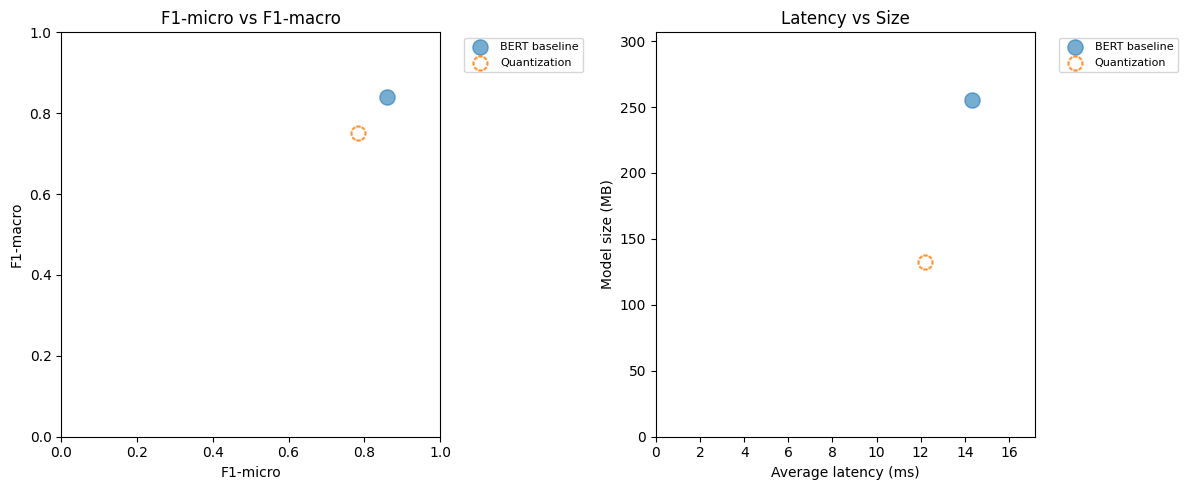

In [17]:
plot_metrics(perf_metrics, optim_type)